In [ ]:
import os
import shutil
import warnings
import csv
import yaml
import json
import torch

from PIL import Image
import pandas as pd
from typing import Any, Sequence

from os import PathLike
from torch.utils.data import Dataset

from megadetector.detection.run_detector import load_detector, model_string_to_model_version
from megadetector.detection.run_detector_batch import process_images, write_results_to_file


from sklearn.model_selection import train_test_split

In [1]:
import random
import torch

import numpy as np
from pathlib import Path
from PIL import Image

from torchvision.transforms import v2
from torch.utils.data import DataLoader

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_config_yaml

paths = load_config_yaml('../path_config.yml')


### Running Tests

In [21]:
path_to_dataset = paths['dataset']
path_labelfiles = paths['test_labels']
path_to_detector_output = paths['md_output']
detector_model='mdv5a'
mode='train'

transform = BatchImagePipeline(
                path_to_dataset=path_to_dataset,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb_fixed', {'crop_shape': 1.0}, )
                ],
                transform = None
                )
                
dataset = MammaliaDataSequence(
    path_labelfiles=path_labelfiles,
    path_to_dataset=path_to_dataset,
    path_to_detector_output=path_to_detector_output,
    detector_model=detector_model,
    mode=mode,
    # transform=transform
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:219: UserWarning: With the detection confidence of 0.25,
8 sequences had no detections and will be excluded.
Excluded sequences: [6000161, 6000163, 6000293, 6000530, 6000691, 6000372, 6000953, 6000186]
  warnings.warn(


In [ ]:
path_to_dataset = paths['dataset']
path_labelfiles = paths['test_labels']
path_to_detector_output = paths['md_output']
detector_model='mdv5a'
mode='train'

transform = ImagePipeline(
                path_to_dataset=path_to_dataset,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb_fixed', {'crop_shape': 1.0}, )
                ],
                transform = None
                )
                
dataset = MammaliaDataImage(
    path_labelfiles=path_labelfiles,
    path_to_dataset=path_to_dataset,
    path_to_detector_output=path_to_detector_output,
    detector_model=detector_model,
    mode=mode,
    transform=transform
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:219: UserWarning: With the detection confidence of 0.25,
8 sequences had no detections and will be excluded.
Excluded sequences: [6000161, 6000163, 6000293, 6000530, 6000691, 6000372, 6000953, 6000186]
  warnings.warn(


In [ ]:
transform1 = ImagePipeline(
                path_to_dataset=path_to_dataset,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb', {'crop_shape': None})
                ],
                transform = None
                )

transform2 = ImagePipeline(
                path_to_dataset=path_to_dataset,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb', {'crop_shape': 1.0})
                ],
                transform = None
                )

transform3 = ImagePipeline(
                path_to_dataset=path_to_dataset,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb', {'crop_shape': 50})
                ],
                transform = None
                )

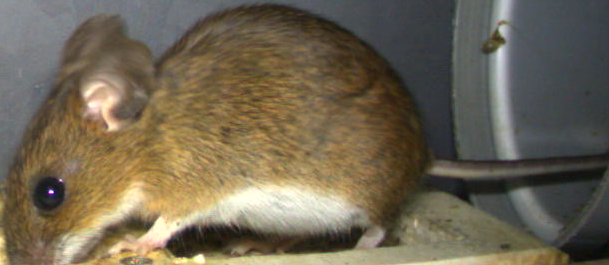

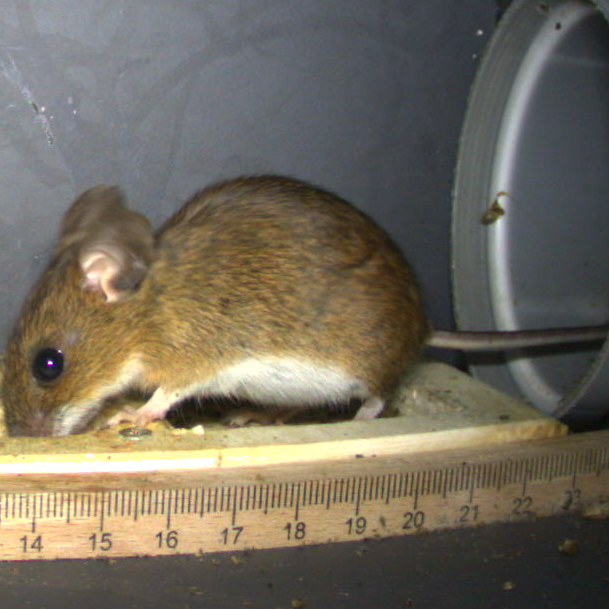

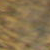

In [20]:
i = 99
file_path = dataset[i]['file_path']
bbox = dataset[i]['bbox']

transform1(file_path, bbox).show()
transform2(file_path, bbox).show()
transform3(file_path, bbox).show()

In [5]:
row = dataset[77]

image = pipline(row['file_path'], row['bbox'])

print(image.shape)

torch.Size([3, 224, 224])


In [5]:
batch_pipline = BatchImagePipeline(
                path_to_dataset=path_to_dataset,
                num_workers=4,
                pre_ops = [
                    ('to_rgb', {}),
                    ('crop_by_bb', {}),
                ],
                transform = None
                )

In [7]:
list_of_paths = []
list_of_bboxes = []

samples = [random.randint(0, len(dataset)) for _ in range(100)]

for i in samples:
    row = dataset[i]

    list_of_paths.append(row['file_path'])
    list_of_bboxes.append(row['bbox'])

images = batch_pipline(list_of_paths, list_of_bboxes)

for image in images:
    print(image.shape)

IndexError: list index out of range

### Tests Feature Stats

In [4]:
path_to_dataset = paths['dataset']
path_labelfiles = paths['test_labels']
path_to_detector_output = paths['md_output']
detector_model=None
mode='init'

transform = ImagePipeline(
                pre_ops=[
                    ('to_rgb', {}),
                    ('crop_by_bb', {})
                ],
                transform=v2.Compose([
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True),
                                ])
                )

dataset = MammaliaDataImage(
    path_labelfiles=path_labelfiles,
    path_to_dataset=path_to_dataset,
    path_to_detector_output=path_to_detector_output,
    detector_model=detector_model,
    mode=mode,
    transform=transform
)

def collate_fn(batch):
    return batch

loader = DataLoader(
    dataset,
    batch_size=10,
    num_workers=1,
    shuffle=False,
    collate_fn=collate_fn
    )

channel_sum = torch.zeros(3)
pixel_count = 0

batches_flat = []

print('Calculating mean...')
for batch in loader:
    for item in batch:
        img = item['x']
        pixel_count += img.shape[1] * img.shape[2]
        for c in range(img.shape[0]):
            channel_sum[c] += img[c].sum()

        batches_flat.append(img.flatten(start_dim=1))

mean = channel_sum / pixel_count

print('Calculating std...')
channel_diff_squared_sum = torch.zeros(3)
for batch in loader:
    for item in batch:
        img = item['x']
        img_centered_squared = (img - mean[:, None, None]) ** 2
        for c in range(img_centered_squared.shape[0]):
            channel_diff_squared_sum[c] += img_centered_squared[c].sum()

std = torch.sqrt(channel_diff_squared_sum / pixel_count)

print("Mean:", mean)
print("Std:", std)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:219: UserWarning: With the detection confidence of 0.25,
8 sequences had no detections and will be excluded.
Excluded sequences: [6000161, 6000163, 6000293, 6000530, 6000691, 6000372, 6000953, 6000186]
  warnings.warn(


Calculating mean...
Calculating std...
Mean: tensor([0.3245, 0.3008, 0.2264])
Std: tensor([0.2232, 0.2075, 0.1725])


In [20]:
torch.cat(batches_flat, -1).mean(-1)

tensor([0.3198, 0.2960, 0.2227])

In [21]:
torch.cat(batches_flat, -1).std(-1)

tensor([0.2246, 0.2083, 0.1730])